In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Unsupervised Learning Part 1 -- Transformation


Many instances of unsupervised learning, such as dimensionality reduction, manifold learning, and feature extraction, find a new representation of the input data without any additional input. (In contrast to supervised learning, usnupervised algorithms don't require or consider target variables like in the previous classification and regression examples). 

<img src="figures/unsupervised_workflow.svg" width="100%">

A very basic example is the rescaling of our data, which is a requirement for many machine learning algorithms as they are not scale-invariant -- rescaling falls into the category of data pre-processing and can barely be called *learning*. There exist many different rescaling technques, and in the following example, we will take a look at a particular method that is commonly called "standardization." Here, we will recale the data so that each feature is centered at zero (mean = 0) with unit variance (standard deviation = 0).

For example, if we have a 1D dataset with the values [1, 2, 3, 4, 5], the standardized values are

- 1 -> -1.41
- 2 -> -0.71
- 3 -> 0.0
- 4 -> 0.71
- 5 -> 1.41

computed via the equation $x_{standardized} = \frac{x - \mu_x}{\sigma_x}$,
where $\mu$ is the sample mean, and $\sigma$ the standard deviation, respectively.






In [2]:
ary = np.array([1, 2, 3, 4, 5])
ary_standardized = (ary - ary.mean()) / ary.std()
ary_standardized

array([-1.41421356, -0.70710678,  0.        ,  0.70710678,  1.41421356])

Although standardization is a most basic preprocessing procedure -- as we've seen in the code snipped above -- scikit-learn implements a `StandardScaler` class for this computation. And in later sections, we will see why and when the scikit-learn interface comes in handy over the code snippet we executed above.  

Applying such a preprocessing has a very similar interface to the supervised learning algorithms we saw so far.
To get some more practice with scikit-learn's "Transformer" interface, let's start by loading the iris dataset and rescale it:


In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print(X_train.shape)

(112, 4)


The iris dataset is not "centered" that is it has non-zero mean and the standard deviation is different for each component:


In [4]:
print("mean : %s " % X_train.mean(axis=0))
print("standard deviation : %s " % X_train.std(axis=0))

mean : [5.88660714 3.05178571 3.79642857 1.22321429] 
standard deviation : [0.86741565 0.43424445 1.79264014 0.77793019] 


To use a preprocessing method, we first import the estimator, here StandardScaler and instantiate it:
    

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

As with the classification and regression algorithms, we call ``fit`` to learn the model from the data. As this is an unsupervised model, we only pass ``X``, not ``y``. This simply estimates mean and standard deviation.

In [6]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Now we can rescale our data by applying the ``transform`` (not ``predict``) method:

In [7]:
X_train_scaled = scaler.transform(X_train)

``X_train_scaled`` has the same number of samples and features, but the mean was subtracted and all features were scaled to have unit standard deviation:

In [8]:
print(X_train_scaled.shape)

(112, 4)


In [9]:
print("mean : %s " % X_train_scaled.mean(axis=0))
print("standard deviation : %s " % X_train_scaled.std(axis=0))

mean : [ 1.21331516e-15 -4.41115398e-17  7.13714802e-17 -3.66770106e-16] 
standard deviation : [1. 1. 1. 1.] 


To summarize: Via the `fit` method, the estimator is fitted to the data we provide. In this step, the estimator estimates the parameters from the data (here: mean and standard deviation). Then, if we `transform` data, these parameters are used to transform a dataset. (Please note that the transform method does not update these parameters).

It's important to note that the same transformation is applied to the training and the test set. That has the consequence that usually the mean of the test data is not zero after scaling:

In [10]:
X_test_scaled = scaler.transform(X_test)
print("mean test data: %s" % X_test_scaled.mean(axis=0))

mean test data: [-0.19692712  0.05042896 -0.08461917 -0.12117658]


It is important for the training and test data to be transformed in exactly the same way, for the following processing steps to make sense of the data, as is illustrated in the figure below:

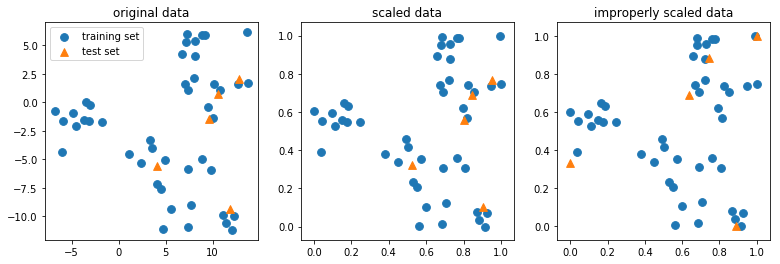

In [11]:
from figures import plot_relative_scaling
plot_relative_scaling()

There are several common ways to scale the data. The most common one is the ``StandardScaler`` we just introduced, but rescaling the data to a fix minimum an maximum value with ``MinMaxScaler`` (usually between 0 and 1), or using more robust statistics like median and quantile, instead of mean and standard deviation (with ``RobustScaler``), are also useful.

In [15]:
from figures import plot_all_scaling
plot_all_scaling()

ImportError: cannot import name 'plot_all_scaling' from 'figures' (G:\DataScienceProjects\scipy-2018-sklearn\notebooks\figures\__init__.py)

In [21]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer, Normalizer, PowerTransformer

In [22]:
PowerTransformer?

Init signature: PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
Docstring:     
Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations
that are applied to make data more Gaussian-like. This is useful for
modeling issues related to heteroscedasticity (non-constant variance),
or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the
Yeo-Johnson transform. The optimal parameter for stabilizing variance and
minimizing skewness is estimated through maximum likelihood.

Box-Cox requires input data to be strictly positive, while Yeo-Johnson
supports both positive or negative data.

By default, zero-mean, unit-variance normalization is applied to the
transformed data.

Read more in the :ref:`User Guide <preprocessing_transformer>`.

Parameters
----------
method : str, (default='yeo-johnson')
    The power transform method. Available

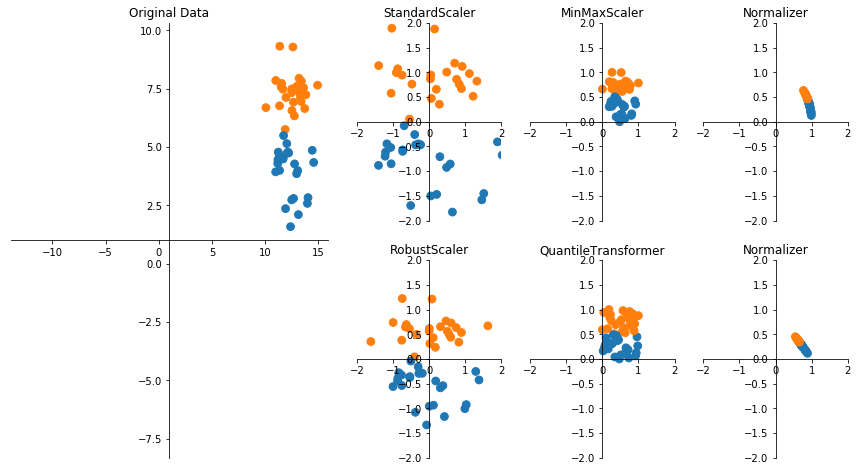

In [16]:
from figures import plot_scaling
plot_scaling()

Principal Component Analysis
============================

An unsupervised transformation that is somewhat more interesting is Principal Component Analysis (PCA).
It is a technique to reduce the dimensionality of the data, by creating a linear projection.
That is, we find new features to represent the data that are a linear combination of the old data (i.e. we rotate it). Thus, we can think of PCA as a projection of our data onto a *new* feature space.

The way PCA finds these new directions is by looking for the directions of maximum variance.
Usually only few components that explain most of the variance in the data are kept. Here, the premise is to reduce the size (dimensionality) of a dataset while capturing most of its information. There are many reason why dimensionality reduction can be useful: It can reduce the computational cost when running learning algorithms, decrease the storage space, and may help with the so-called "curse of dimensionality," which we will discuss in greater detail later.

To illustrate how a rotation might look like, we first show it on two-dimensional data and keep both principal components. Here is an illustration:



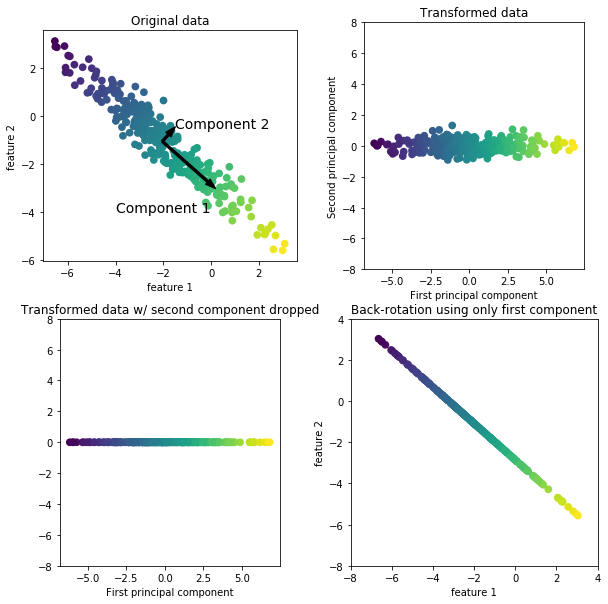

In [25]:
from figures import plot_pca_illustration
plot_pca_illustration()

Now let's go through all the steps in more detail:
We create a Gaussian blob that is rotated:

In [31]:
rnd.normal(size=(2, 2))

array([[ 0.83578668, -0.44626167],
       [ 0.33444856, -0.39428211]])

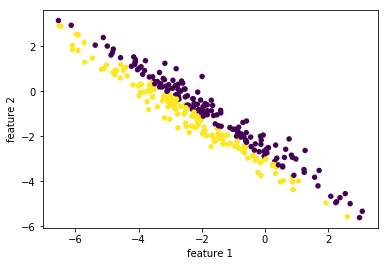

In [26]:
rnd = np.random.RandomState(5)
X_ = rnd.normal(size=(300, 2))
X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2)
y = X_[:, 0] > 0
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("feature 1")
plt.ylabel("feature 2");

As always, we instantiate our PCA model. By default all directions are kept.

In [35]:
PCA?

Init signature:
PCA(
    n_components=None,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float, None or string
    Number of components to keep.
    if n_components is not set all components are kept::

        n_components == min(n_samples, n_features)

    If

In [32]:
from sklearn.decomposition import PCA
pca = PCA()

Then we fit the PCA model with our data. As PCA is an unsupervised algorithm, there is no output ``y``.

In [36]:
pca.fit(X_blob)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [37]:
pca.components_

array([[ 0.74827666, -0.6633868 ],
       [ 0.6633868 ,  0.74827666]])

In [38]:
pca.singular_values_ 

array([43.96895003,  6.59698457])

In [39]:
pca.n_components_ 

2

In [40]:
pca.explained_variance_ 

array([6.46578116, 0.14555253])

In [41]:
pca.explained_variance_ratio_ 

array([0.97798439, 0.02201561])

Then we can transform the data, projected on the principal components:

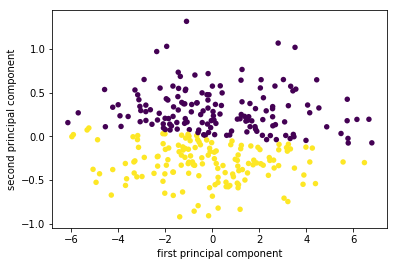

In [42]:
X_pca = pca.transform(X_blob)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, linewidths=0, s=30)
plt.xlabel("first principal component")
plt.ylabel("second principal component");

In [43]:
pca = PCA(n_components=1).fit(X_blob)

In [44]:
X_blob.shape

(300, 2)

In [45]:
pca.transform(X_blob).shape

(300, 1)

On the left of the plot you can see the four points that were on the top right before. PCA found fit first component to be along the diagonal, and the second to be perpendicular to it. As PCA finds a rotation, the principal components are always at right angles ("orthogonal") to each other.

Dimensionality Reduction for Visualization with PCA
-------------------------------------------------------------
Consider the digits dataset. It cannot be visualized in a single 2D plot, as it has 64 features. We are going to extract 2 dimensions to visualize it in, using the example from the sklearn examples [here](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)

Computing PCA projection


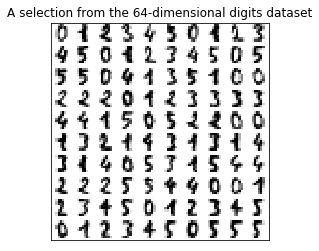

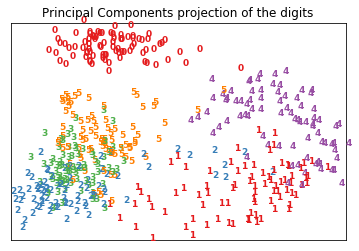

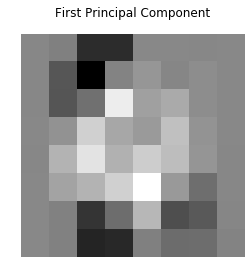

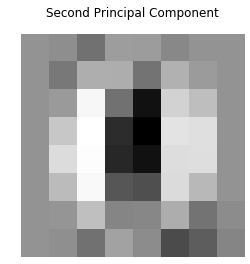

In [46]:
from figures import digits_plot

digits_plot()

Note that this projection was determined *without* any information about the
labels (represented by the colors): this is the sense in which the learning
is **unsupervised**.  Nevertheless, we see that the projection gives us insight
into the distribution of the different digits in parameter space.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
        Visualize the iris dataset using the first two principal components, and compare this visualization to using two of the original features.
      </li>
    </ul>
</div>

In [47]:
from sklearn.datasets import load_iris

In [48]:
iris_data = load_iris()

In [50]:
iris_data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [51]:
iris_data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [67]:
import pandas as pd
import seaborn as sns

In [55]:
iris_df = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)
#iris_df['target'] = iris_data.target

In [57]:
pca_iris = PCA(n_components=2)

In [60]:
iris_df_pca = pd.DataFrame(pca_iris.fit_transform(iris_df), columns = ['comp1','comp2'])

In [61]:
iris_df_pca['target'] = iris_data.target

In [63]:
iris_df_pca.head()

,comp1,comp2,target
0,-2.684126,0.319397,0
1,-2.714142,-0.177001,0
2,-2.888991,-0.144949,0
3,-2.745343,-0.318299,0
4,-2.728717,0.326755,0


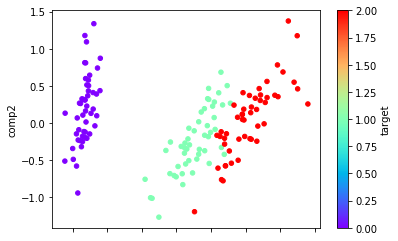

In [74]:
iris_df_pca.plot(x='comp1',y='comp2',c='target', kind='scatter', colormap='rainbow')
plt.show()

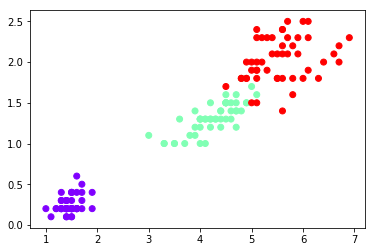

In [82]:
plt.scatter(x=iris_df.iloc[:,2],y=iris_df.iloc[:,3],c=iris_data.target,  cmap='rainbow')
plt.show()

In [ ]:
# %load solutions/07A_iris-pca.py